# Survival analysis

## 1 Setup

Flags

In [1]:
SAVE_FIGURES = False
STOPWORDS = 'include'  # 'include' or 'exclude'

Setup the database

In [2]:
import os, sys
sys.path.insert(1, os.path.abspath('../..'))
import analysis

FIG = os.path.join(os.path.abspath(os.path.curdir), '{}.png')
DB_NAME = 'spreadr_' + os.path.split(os.path.abspath(os.path.curdir))[1]
analysis.setup(DB_NAME)
print('Database:', DB_NAME)

Database: spreadr_exp_3


Imports for the analysis

In [39]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Patch
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sb
import lifelines

from gists.models import Sentence, Tree, GistsConfiguration

from analysis.utils import memoized, mpl_palette

config = GistsConfiguration.get_solo()

In [7]:
# Lifetime of stabilisation

# for tree in trees
#   for each branch under root
#     walking down the branch:
#       if no change from parent:
#         if not set, set birth=parent.depth, and record parent features
#         if set, continue
#       else:
#         if birth set:
#           record duration = now - birth - 1, store with features in DF
#           unset birth & features
#         if birth not set: continue
#       if leaf, and birth set, store with right-censorship

In [8]:
# Lifetime of chaos

# for tree in trees
#   for each branch under root
#     walking down the branch:
#       if change from parent:
#         if not set, set birth=parent.depth, and record parent features
#         if set, continue
#       else:
#         if birth set:
#           record duration = now - birth - 1, store with features in DF
#           unset birth & features
#         if birth not set: continue
#       if leaf, and birth set, store with right-censorship

## 2 Lifetime of stabilizations

### 2.0 Setup

We need an additional feature-building function, and some helpers

In [9]:
def _stopword_proportion(self, _):
    """stopword %"""
    return 1 - (len(self.content_tokens) / len(self.tokens))

Sentence._stopword_proportion = _stopword_proportion
Sentence.SENTENCE_FEATURES.add('stopword_proportion')

In [10]:
def branch_sentences(head):
    current = head
    while current.children.kept.count() > 0 and current.depth < config.target_branch_depth:
        if current.children.kept.count() > 1:
            raise ValueError("More than one (kept) children for sentence {}"
                             .format(current.id))
        yield current
        current = current.children.kept.first()
    
    # Yield the final leaf
    yield current

In [11]:
def additional_features(sentence):
    return {
        'incoming_oc_rate': np.nan if sentence.parent is None else sentence.oc_distance(sentence.parent),
        'token_length': len(sentence.tokens),
        'content_length': len(sentence.content_tokens),
    }

def base(sentence, branch_head):
    return {
        # indices
        'tree_id': sentence.tree.id,
        'sentence_id': sentence.id,
        'branch_id': branch_head.id,
        # independent variables
        'depth': sentence.depth,
        'is_root': sentence.parent is None,
    }

def rows(sentence, branch_head):
    for fname in set(Sentence.WORD_FEATURES.keys()).union(Sentence.SENTENCE_FEATURES):
        row = base(sentence, branch_head)
        row.update({'feature': fname, 'value': sentence.feature(fname, stopwords=STOPWORDS)})
        yield row
    
    for fname, fvalue in additional_features(sentence).items():
        row = base(sentence, branch_head)
        row.update({'feature': fname, 'value': fvalue})
        yield row

Then build the master DataFrame that we'll plot below

In [18]:
data = []
for tree in Tree.objects.experiment:
    for head in tree.root.children.kept:

        start = None
        for sentence in branch_sentences(head):
            
            if sentence.oc_distance(sentence.parent) == 0:
                if start is None:
                    # No change from parent, and no stabilization recorded,
                    # so this is the start of a new one
                    start = sentence.parent
                else:
                    # We're in a stabilization
                    pass
            else:
                # Change from parent
                if start is None:
                    # No previous stabilization recorded,
                    # i.e. we're not terminating anything
                    duration = 0
                else:
                    # We have a previous stabilization recorded,
                    # so the parent is its end
                    duration = sentence.parent.depth - start.depth
                
                for row in rows(start or sentence.parent, head):
                    row.update({'duration': duration, 'observed': True})
                    data.append(row)
                    
                start = None
        
        if start is not None:
            # Leaf is in a stabilization, store as right-censored
            duration = sentence.depth - start.depth
            for row in rows(start, head):
                row.update({'duration': duration, 'observed': False})
                data.append(row)

data = pd.DataFrame(data)

features = sorted(set(data.feature))
index = sorted(set(data.columns).difference(['value', 'feature']))

/home/sl/Code/Research/interpretation-experiment/analysis/analysis/features.py:310: RuntimeWarning: Mean of empty slice
  return np.nanmean(self.features(name, stopwords=stopwords))



A helper function to reshape the DataFrame as needed

In [20]:
def extract_features(df, df_index, features):
    edf = pd.melt(df.pivot_table(index=df_index, columns='feature', values='value').reset_index(),
                  id_vars=df_index + features, var_name='feature')
    efeatures = sorted(set(edf.feature).difference(features))
    return edf, efeatures

And define a few plotting functions

In [23]:
def plot_relation(x, y, **kwargs):
    color = kwargs.get('color', sb.color_palette()[0])
    data = kwargs['data']
    ax = kwargs.get('ax', plt.gca())
    binning = kwargs.get('binning')
    quantiles = kwargs.get('quantiles', False)
    label = kwargs.get('label')
    if 'sentence_id' in data.columns:
        # Average repeated measures (which we have for the roots)
        data = data.groupby('sentence_id', as_index=False).mean()
    x = data[x]
    y = data[y]
    
    # Compute binning
    if binning is not None:
        cut, cut_kws = ((pd.qcut, {}) if quantiles
                        else (pd.cut, {'right': False}))
        for bin_count in range(binning, 0, -1):
            try:
                x_bins, bins = cut(x, bin_count, labels=False,
                                   retbins=True, **cut_kws)
                break
            except ValueError:
                pass
        if bin_count <= 1:
            return
        middles = (bins[:-1] + bins[1:]) / 2
    else:
        middles = np.arange(x.values.min(), x.values.max() + 1)
        x_bins = x.values - x.values.min()
        bin_count = len(middles)

    # Compute features per depth
    heights = np.zeros(bin_count)
    cis = np.zeros(bin_count)
    for i in range(bin_count):
        indices = x_bins == i
        n = indices.sum()
        heights[i] = y[indices].mean()
        cis[i] = (stats.t.ppf(.975, n - 1) * y[indices].std(ddof=1)
                  / np.sqrt(n))

    # Plot
    #ax.scatter(x, y, marker='+', color=color)
    ax.plot(middles, heights, color=color)
    ax.fill_between(middles, heights - cis, heights + cis,
                    color=sb.desaturate(color, 0.2), alpha=0.2)

    if label is not None:
        # Add a dummy scatterplot so we can get legend data
        ax.scatter([], [], color=color, label=label)

### 2.1 Stability duration

#### 2.1.1 Stability duration ~ feature

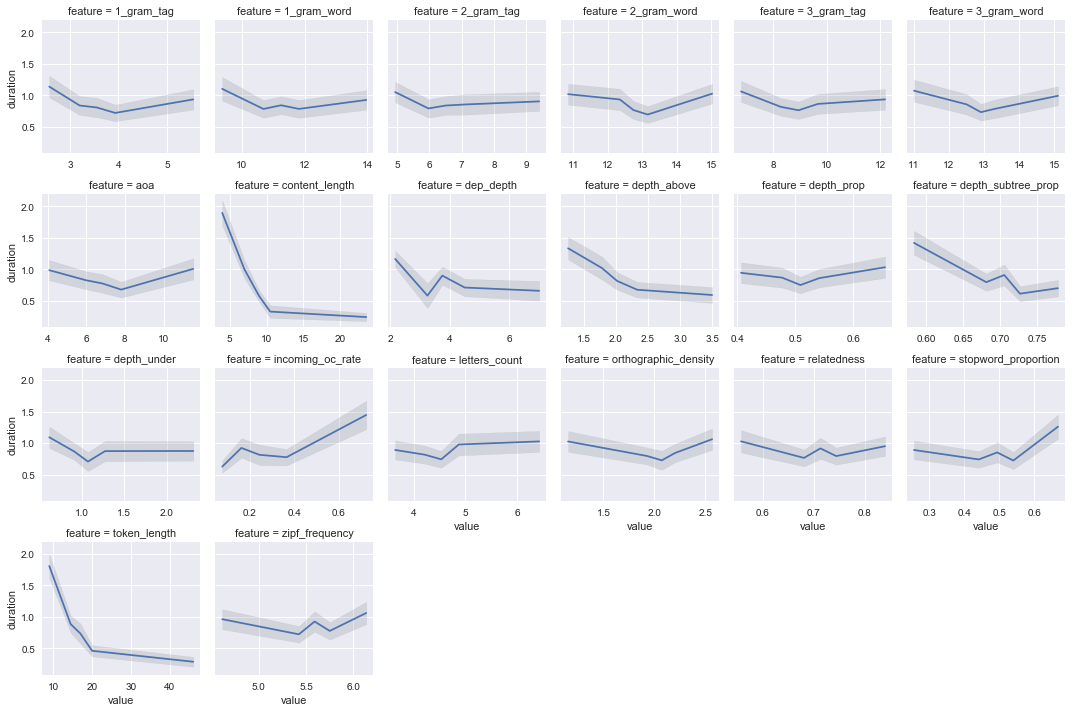

In [38]:
g = sb.FacetGrid(data=data,#[data.duration > 0],
                 dropna=False, col='feature', col_order=features,
                 col_wrap=6, size=2.5, sharex=False)
g.map_dataframe(plot_relation, 'value', 'duration', binning=5, quantiles=True).add_legend()
#g.set(ylim=(0, 2))

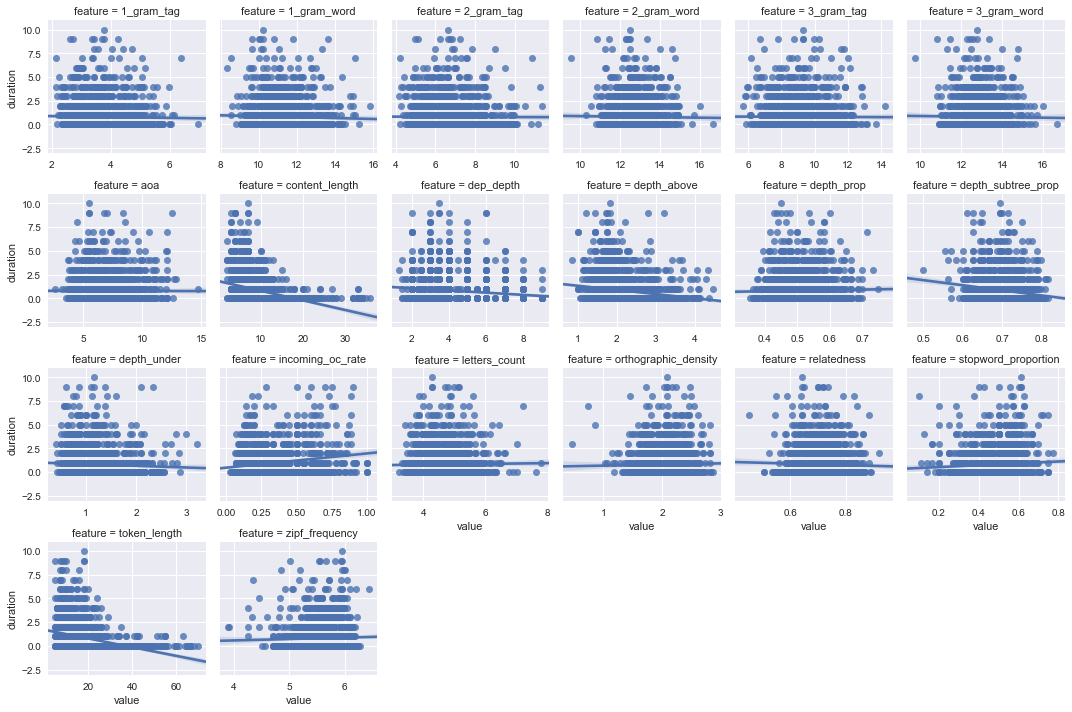

In [33]:
g = sb.FacetGrid(data=data,#[data.duration > 1],
                 dropna=False, col='feature', col_order=features,
                 col_wrap=6, size=2.5, sharex=False)
g.map_dataframe(sb.regplot, 'value', 'duration')
#g.set(ylim=(0, .09))

#### 2.1.2 Stability duration ~ feature / number of content words

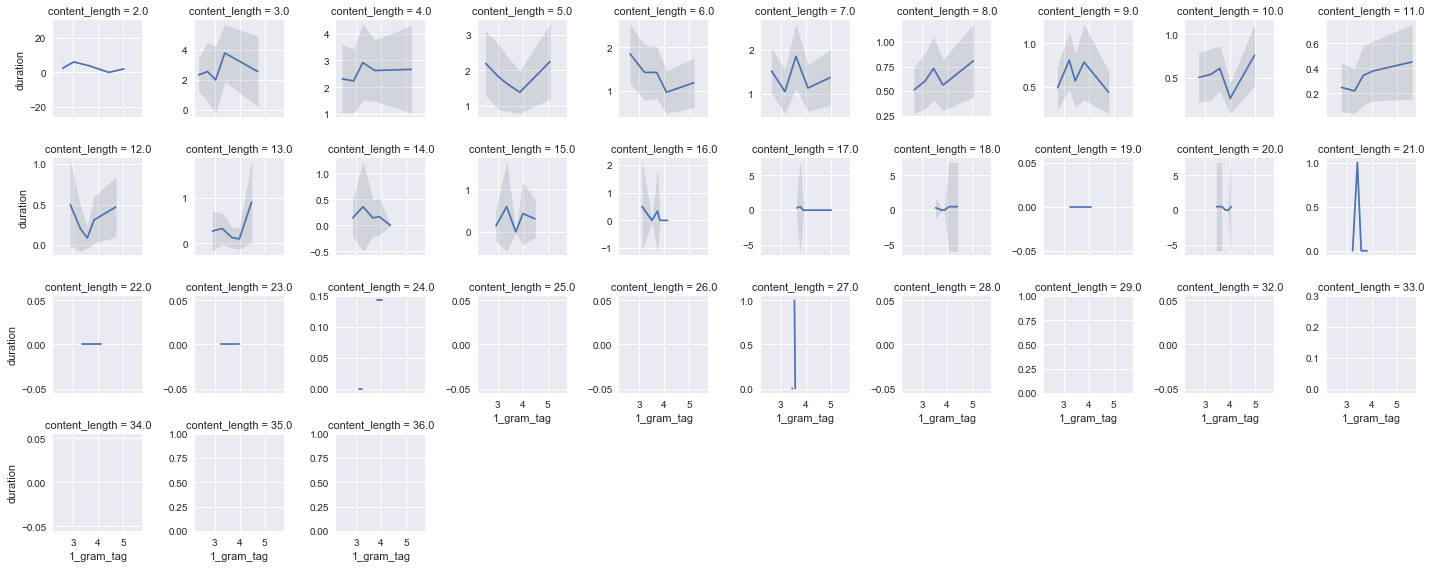

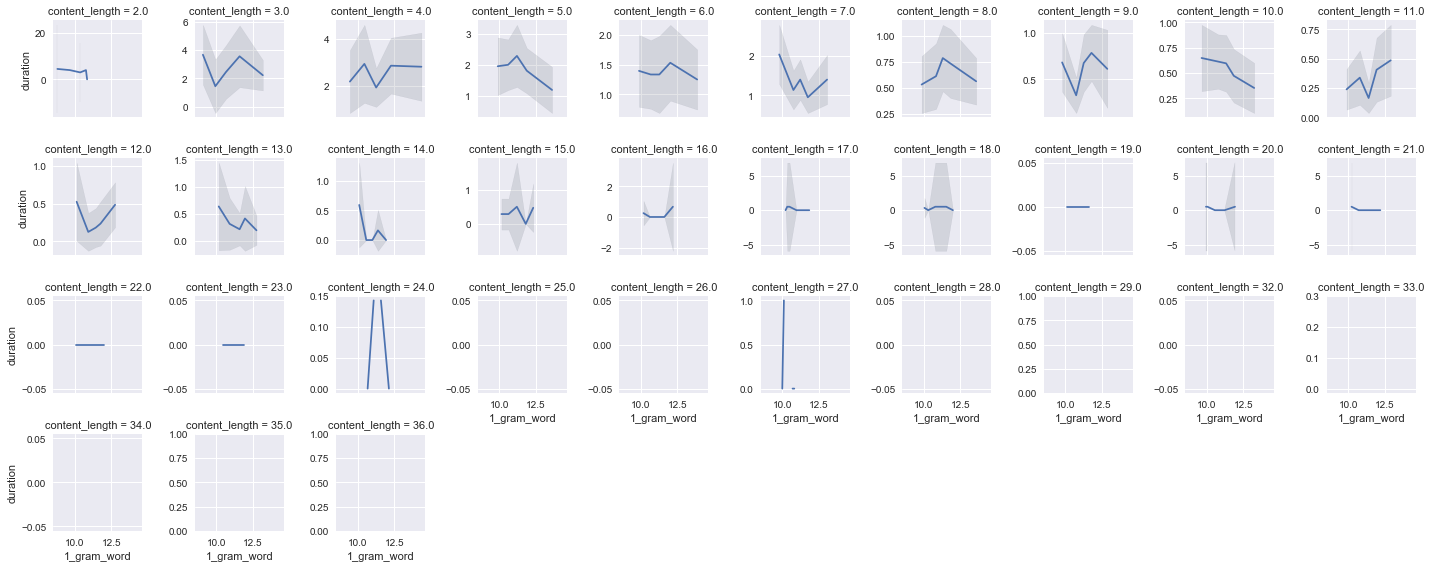

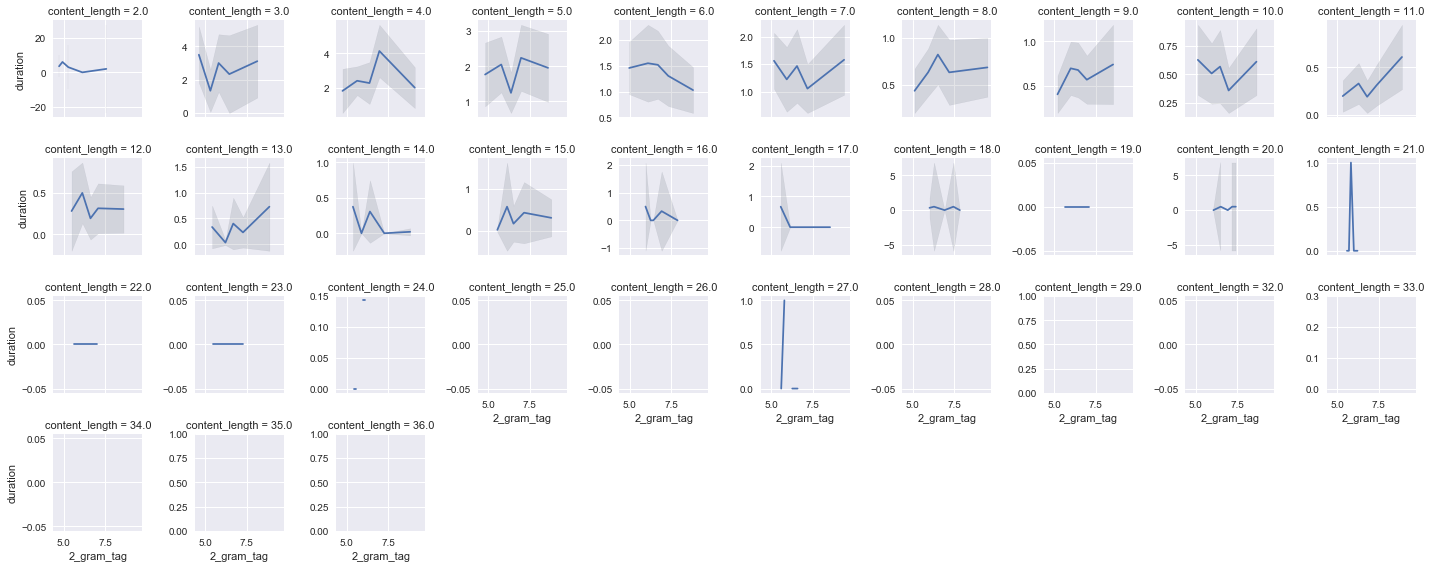

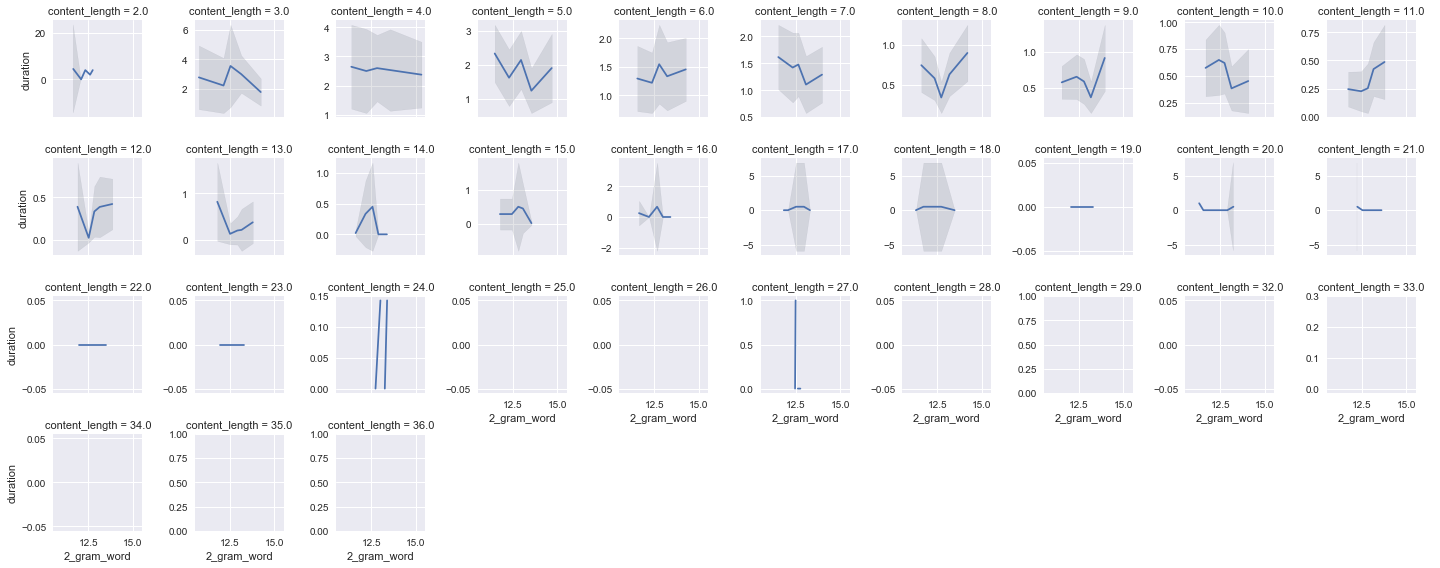

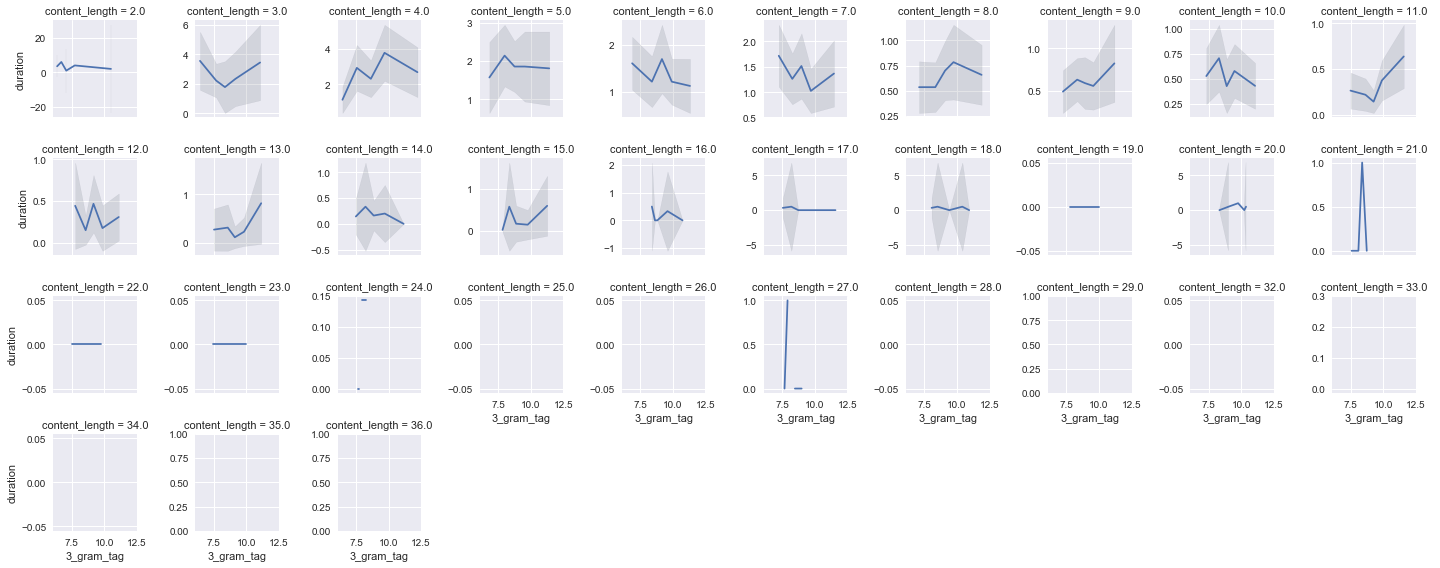

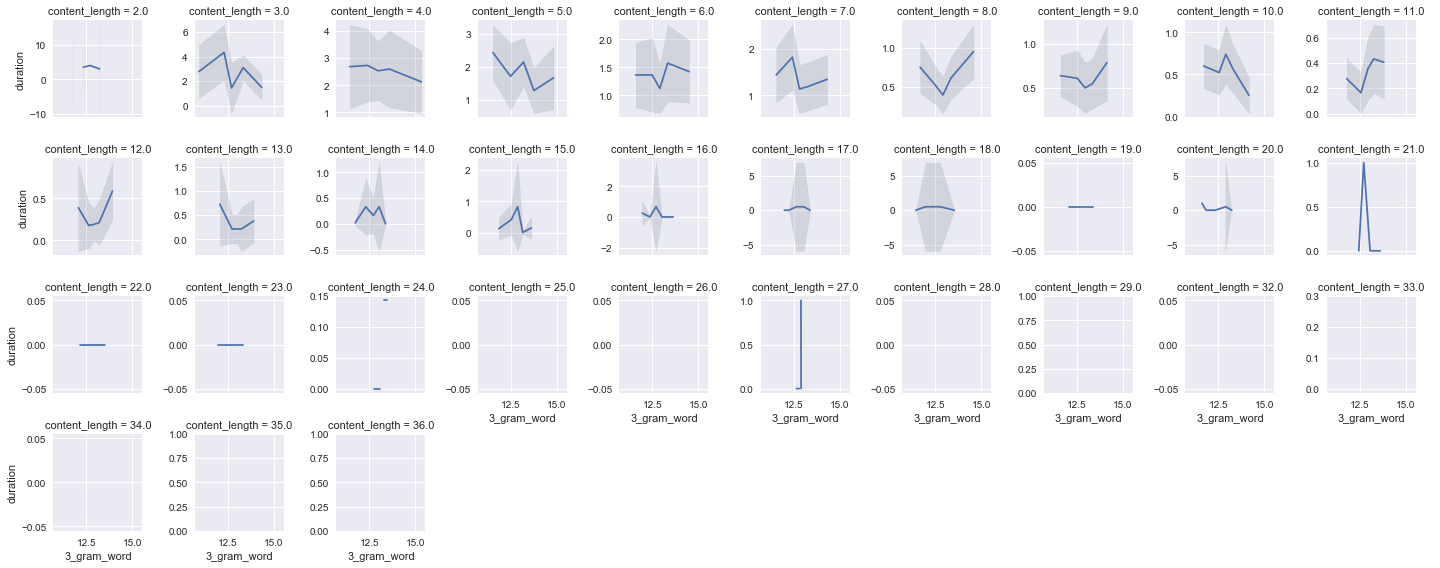

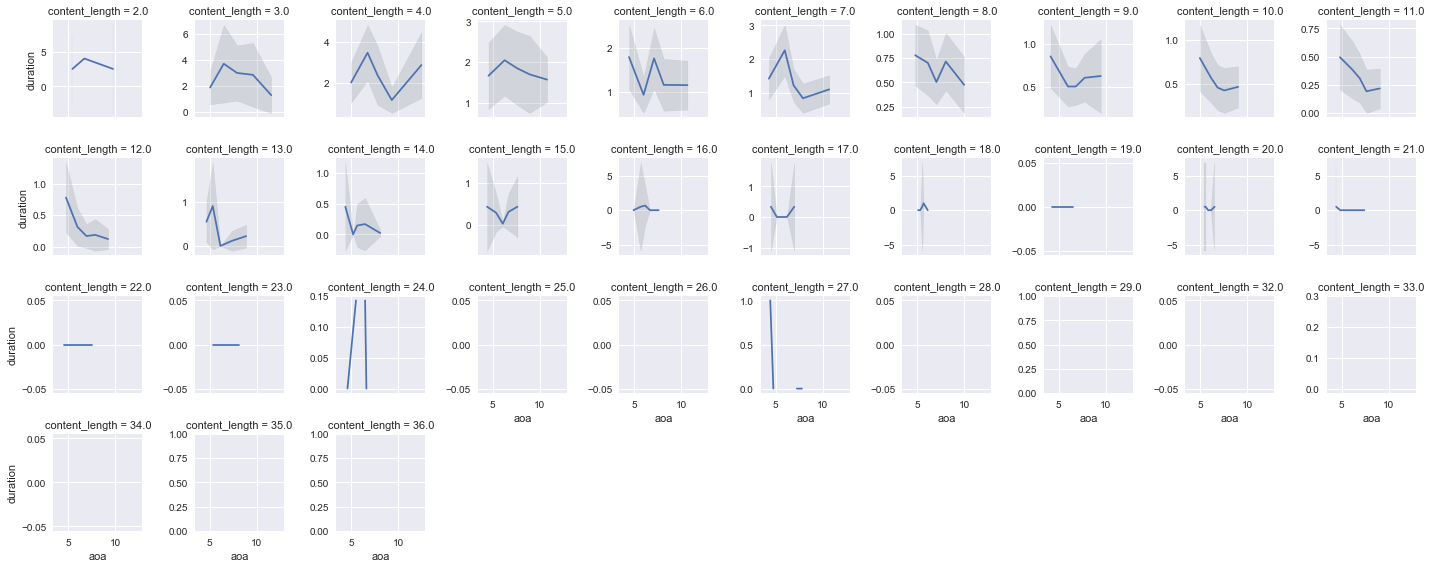

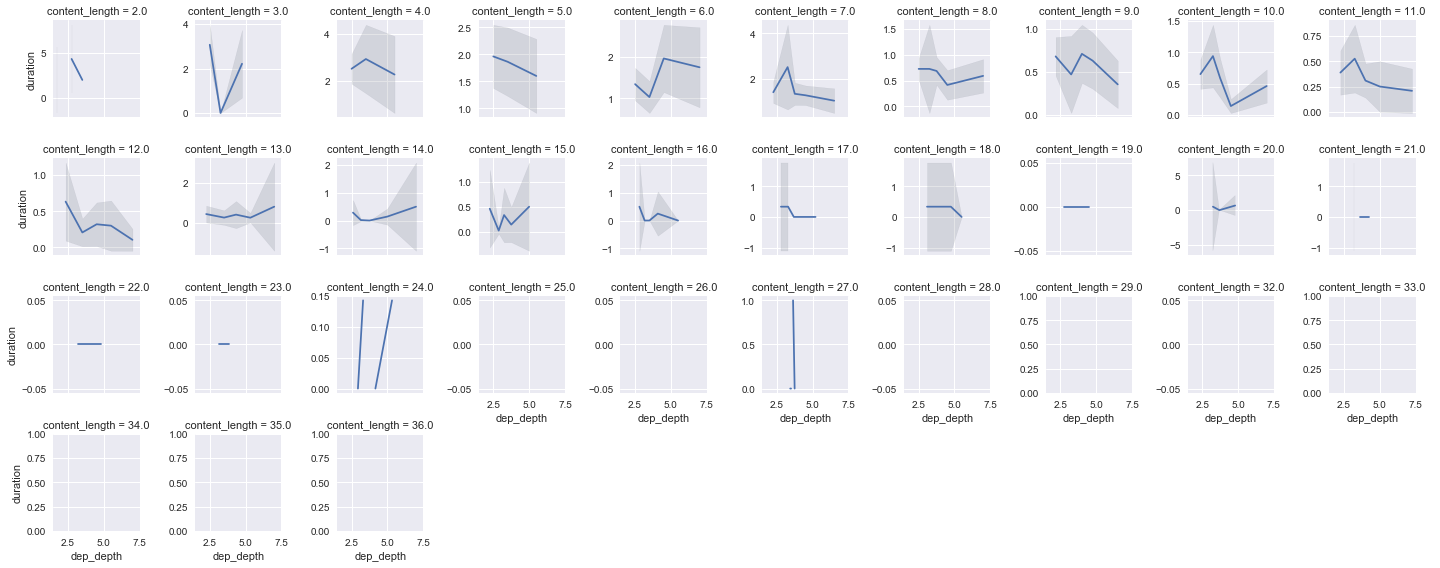

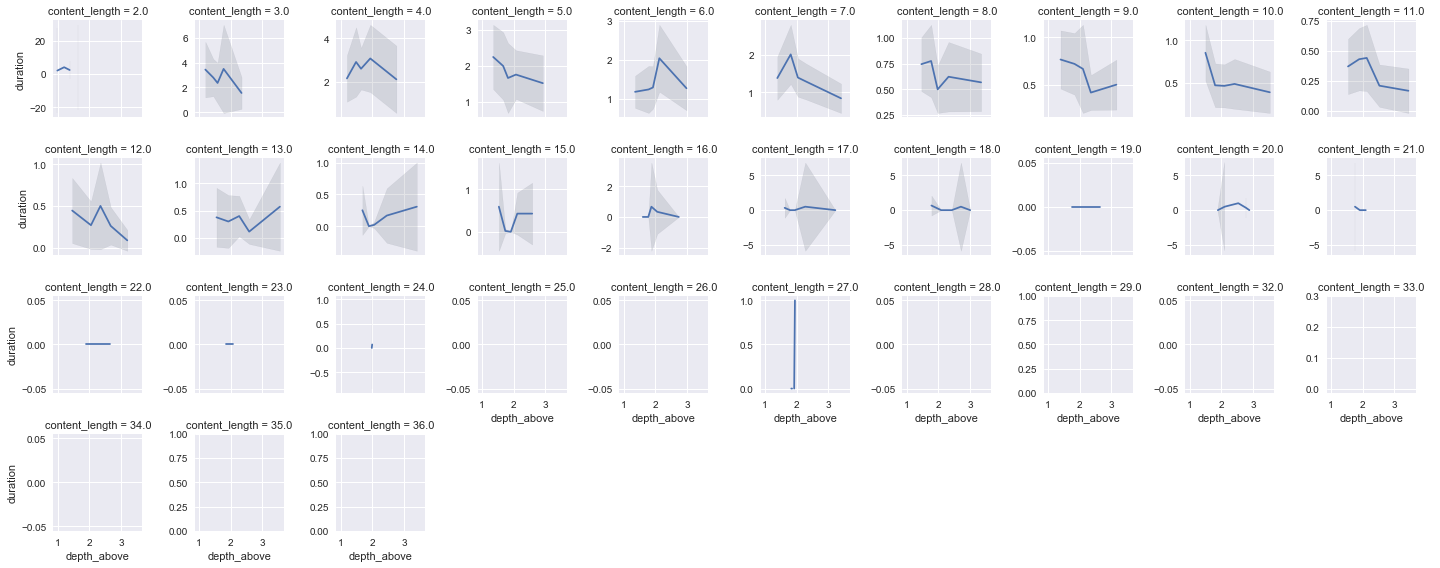

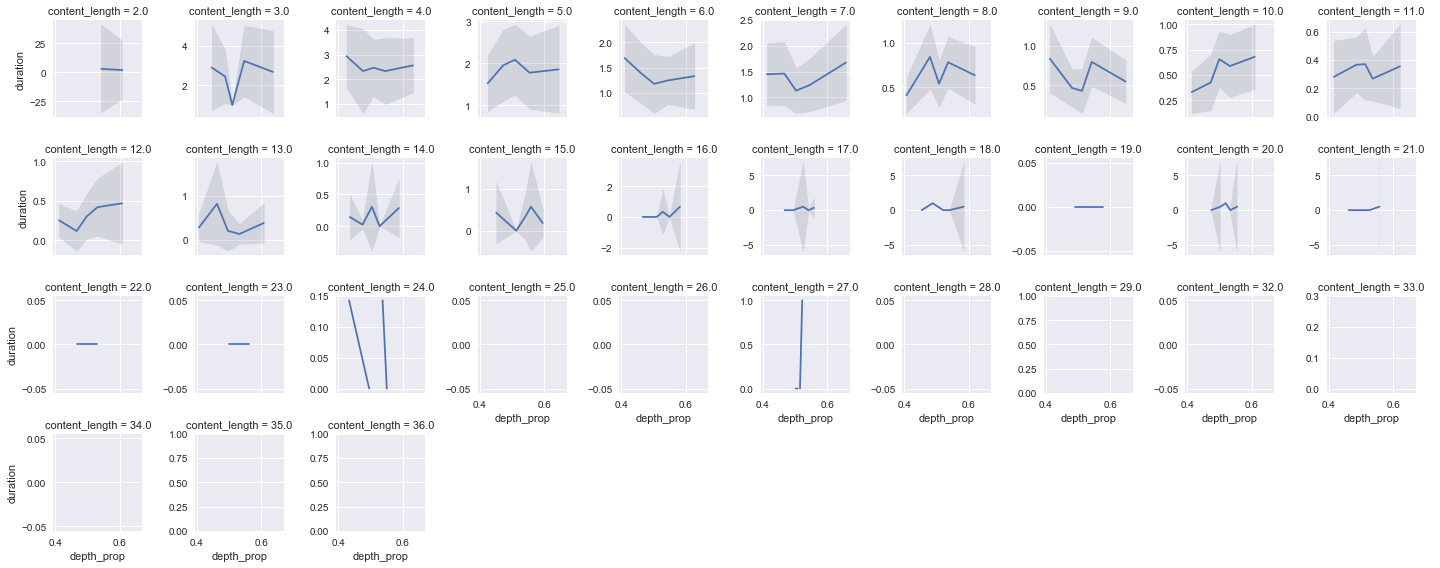

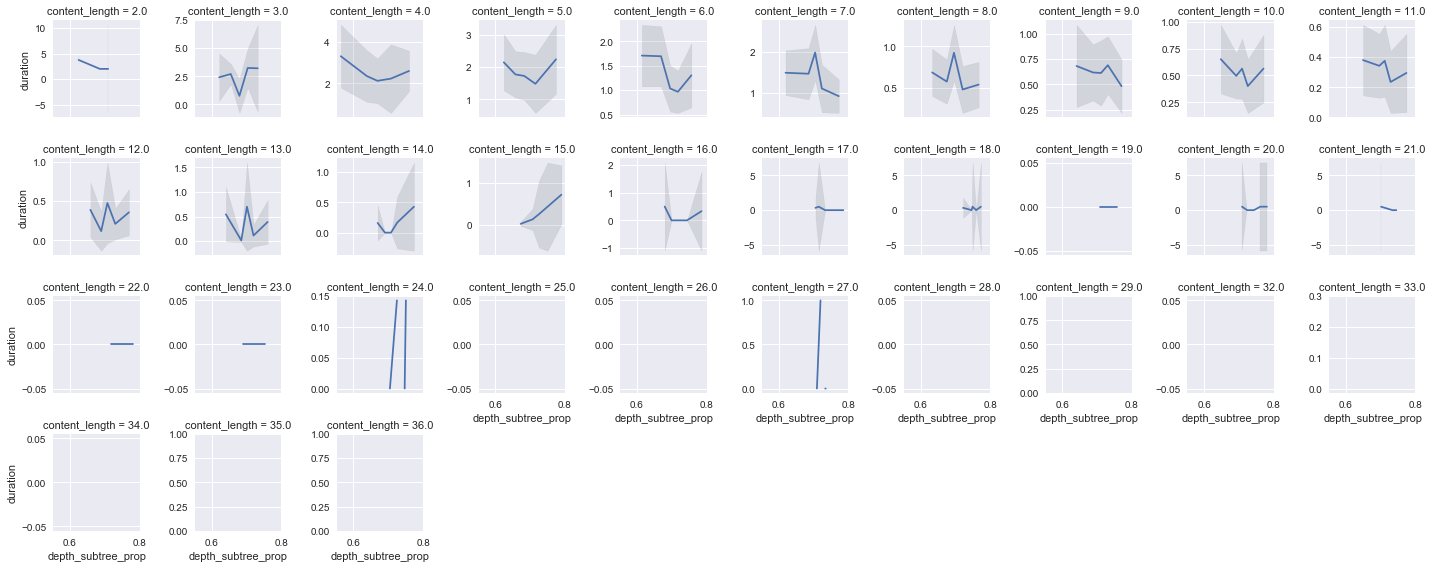

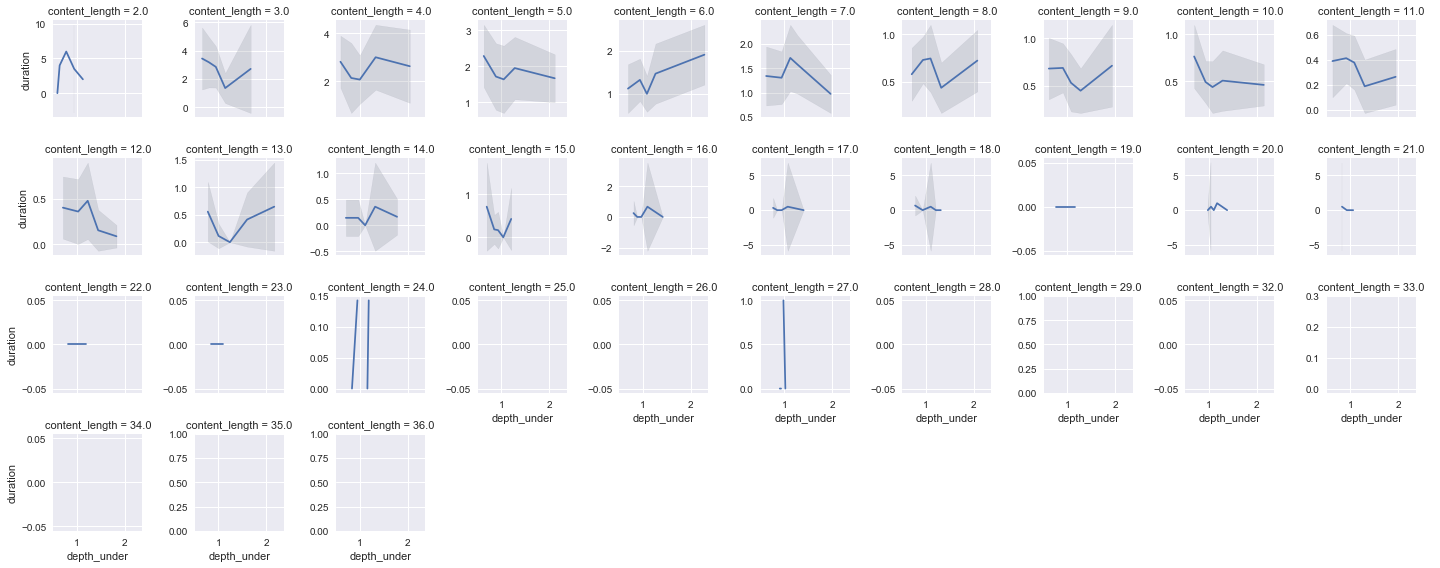

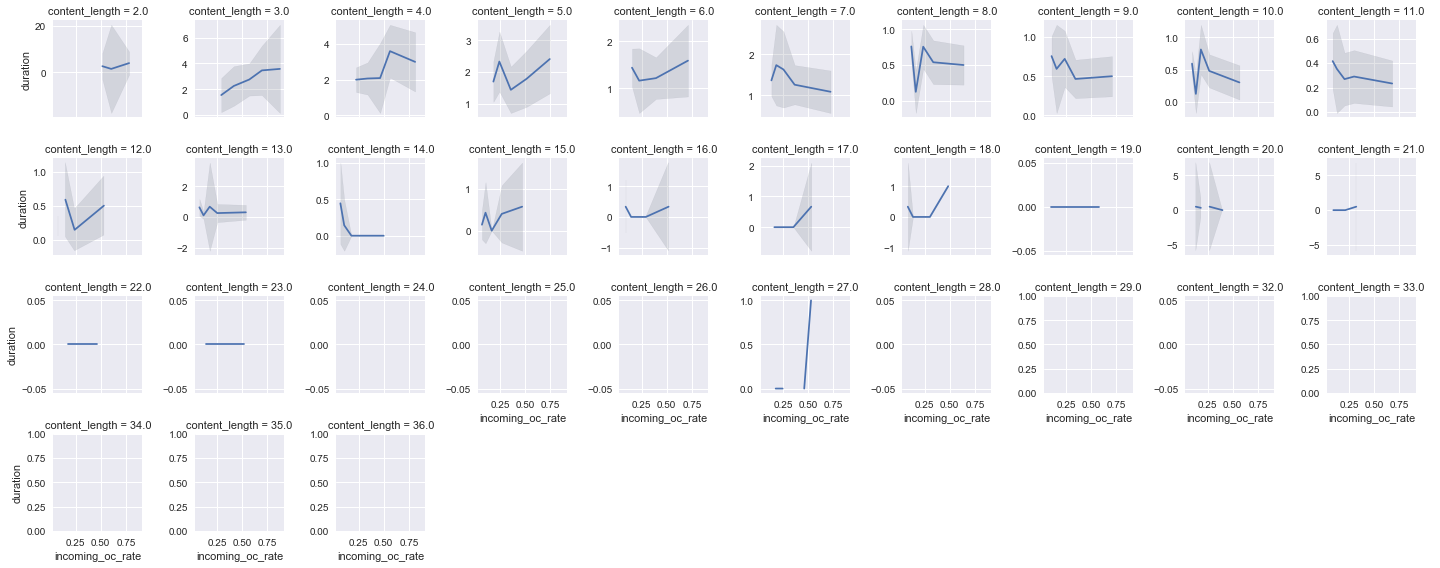

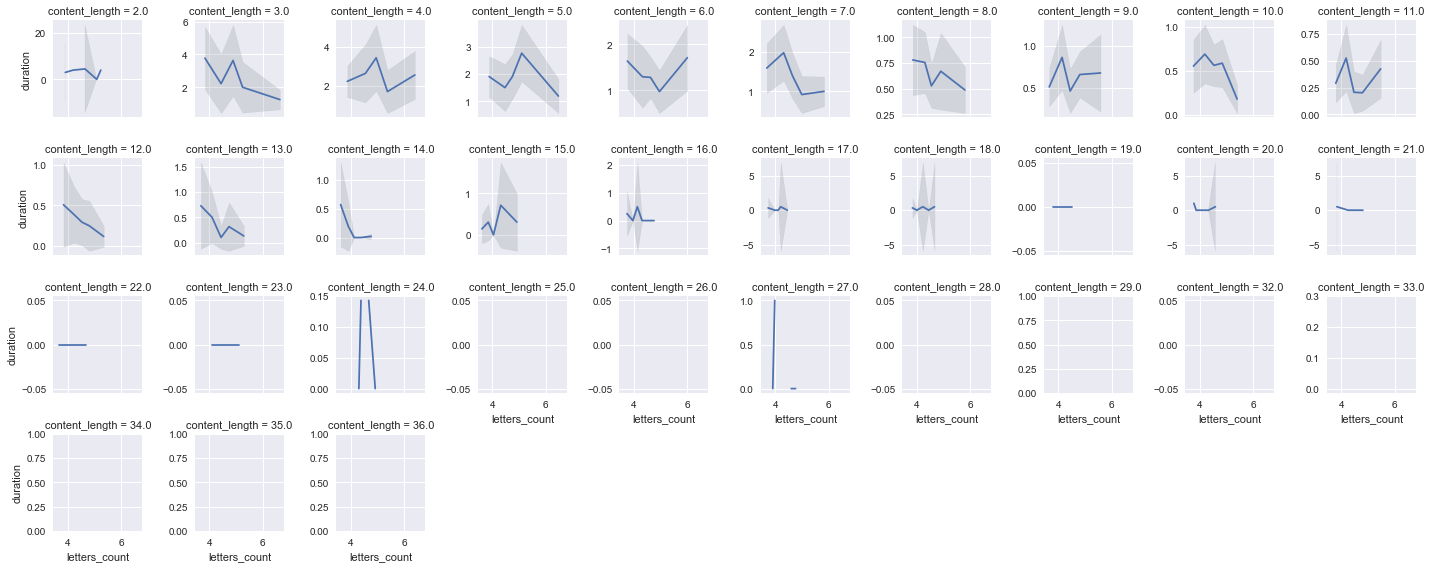

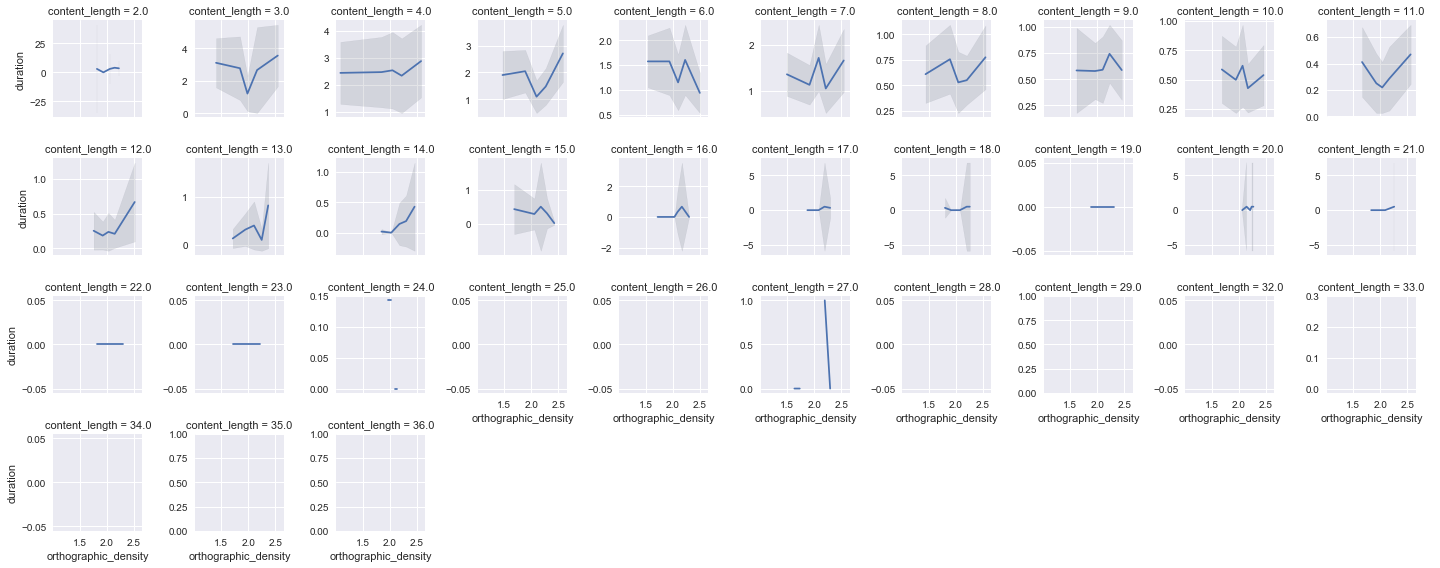

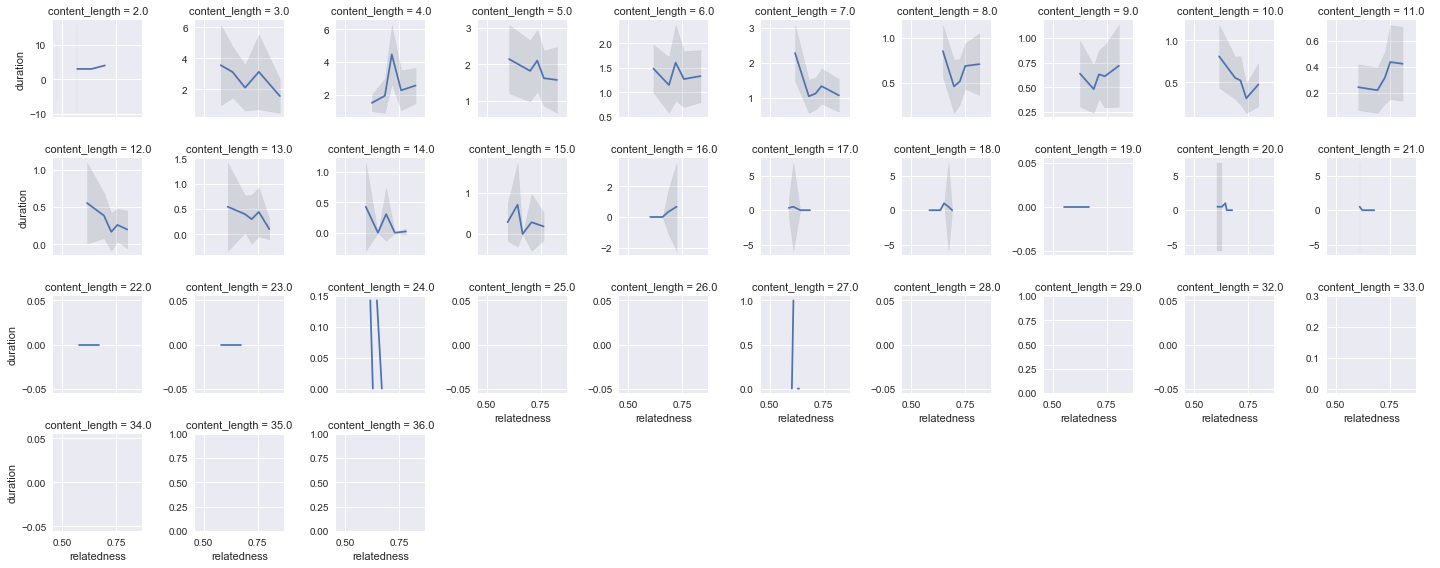

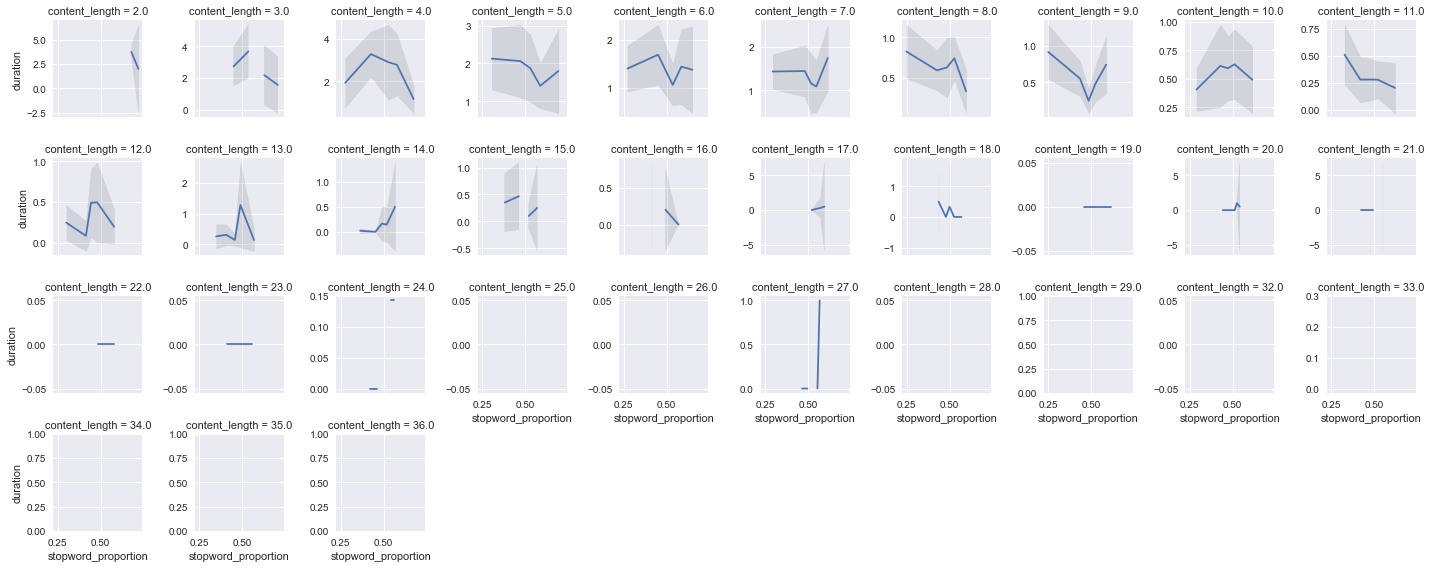

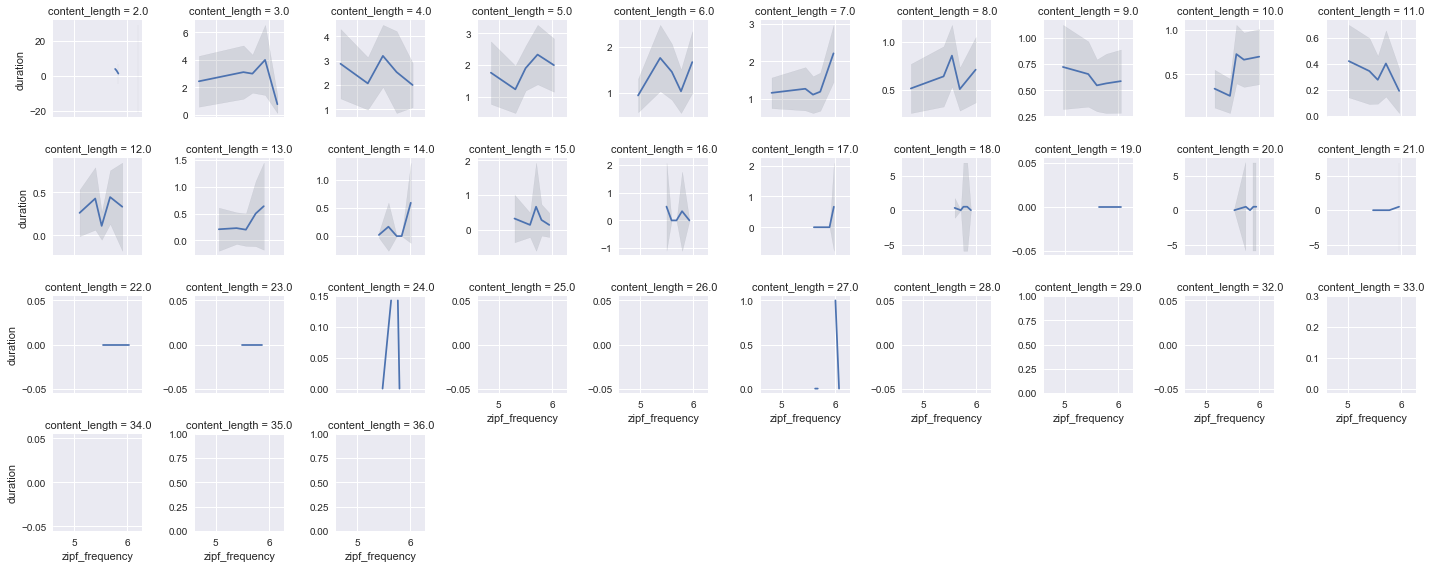

In [30]:
data_lengths, features_lengths = extract_features(data, index, ['token_length', 'content_length'])
for feature in features_lengths:
    g = sb.FacetGrid(data=data_lengths[data_lengths.feature == feature],
                     dropna=False, col='content_length',
                     sharey=False,
                     col_wrap=10, size=2)
    g.map_dataframe(plot_relation, 'value', 'duration',
                    binning=5, quantiles=True).add_legend()
    g.set_xlabels(feature)

### 2.2 Survival analysis

In [69]:
def plot_survivals(**kwargs):
    data = kwargs['data']
    ax = kwargs.get('ax', plt.gca())
    fitter_class = kwargs['fitter']
    quantiles = kwargs.get('quantiles', False)
    binning = kwargs['binning']
    feature = data.feature.iloc[0]
    values = data.value.values
    
    # Compute binning
    cut, cut_kws = ((pd.qcut, {}) if quantiles
                    else (pd.cut, {'right': False}))
    value_bins, bins = cut(values, binning, labels=False,
                           retbins=True, **cut_kws)
    
    # Fit and plot
    fitter = fitter_class()
    for i in range(binning):
        fitter.fit(data[value_bins == i].duration, event_observed=data[value_bins == i].observed,
                   label="{} <= {} < {}".format(bins[i], feature, bins[i+1]))
        fitter.plot(ax=ax)

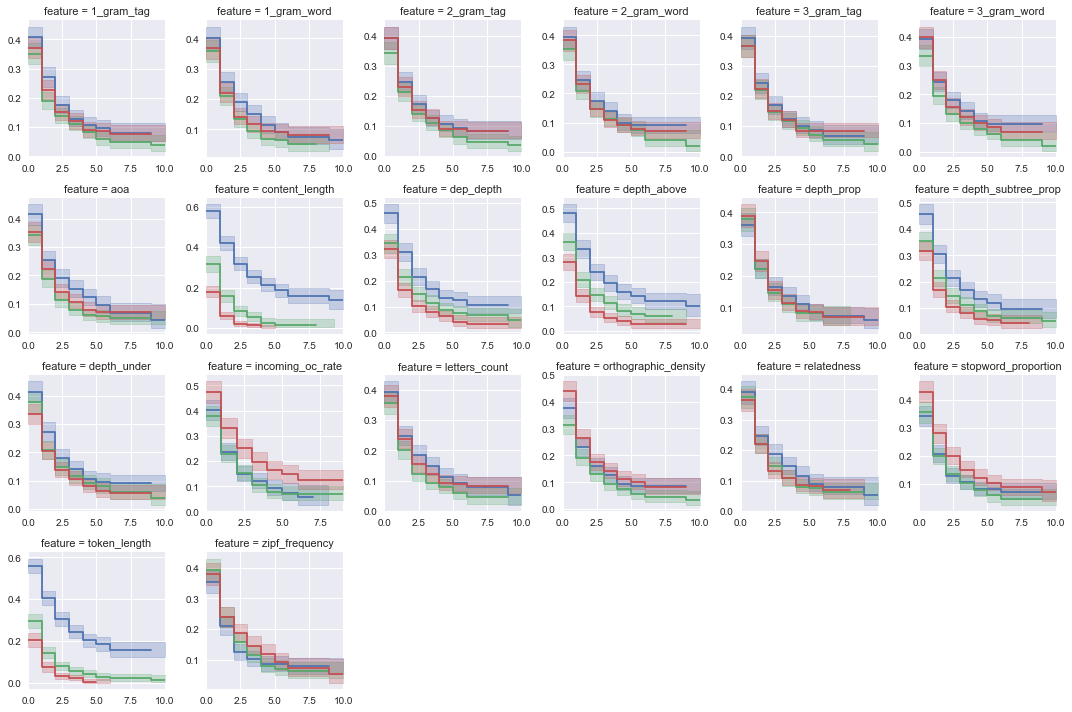

In [70]:
g = sb.FacetGrid(data=data,#[data.duration > 1],
                 dropna=False, col='feature', col_order=features,
                 col_wrap=6, size=2.5, sharex=False, sharey=False)
g.map_dataframe(plot_survivals, binning=3, quantiles=True,
                fitter=lifelines.KaplanMeierFitter)#.add_legend()

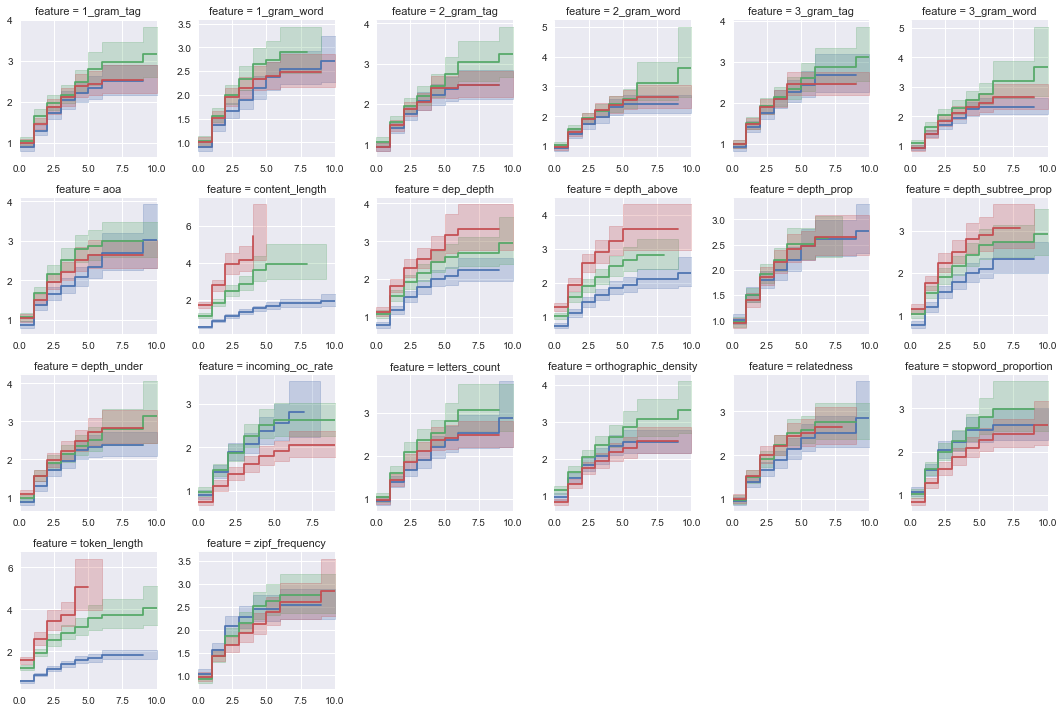

In [71]:
g = sb.FacetGrid(data=data,#[data.duration > 1],
                 dropna=False, col='feature', col_order=features,
                 col_wrap=6, size=2.5, sharex=False, sharey=False)
g.map_dataframe(plot_survivals, binning=3, quantiles=True,
                fitter=lifelines.NelsonAalenFitter)#.add_legend()